In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

In [2]:
# Load data
df = pd.read_csv(r".\Data\train_data.csv")
ts_df = pd.read_csv(r".\Data\test_data.csv")

In [3]:
# Feature processing
def preprocess_data(df):
    features = ["temp", "atemp", "hum", "windspeed", "season", "weekday", "hr", "holiday", "weathersit", "workingday"]
    target = "cnt"
    df_features = df[features]
    df.dropna(inplace=True)
    df_target = df[target]
    return df_features.values, df_target.values

X, y = preprocess_data(df)
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y.reshape(-1, 1))
tX, ty = preprocess_data(ts_df)
ty = scaler.fit_transform(ty.reshape(-1, 1))
print(len(df))

15216


In [4]:
# Dataset definition
class BikeDataset(Dataset):
    def __init__(self, X, y, input_len=96, output_len=240):
        self.X = X
        self.y = y
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.X) - self.input_len - self.output_len + 1

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx + self.input_len], dtype=torch.float32),
            torch.tensor(self.y[idx + self.input_len:idx + self.input_len + self.output_len], dtype=torch.float32),
        )

In [5]:
# Create data loaders
train_dataset = BikeDataset(X, y, input_len=96, output_len=240)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = BikeDataset(tX, ty, input_len=96, output_len=240)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(train_dataset.__len__())

14881


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Transformer model
class TransformerModel(nn.Module):
        def __init__(self, input_dim, output_dim, seq_len, hidden_dim=512, nhead=4, num_encoder_layers=3):
            super(TransformerModel, self).__init__()
            self.embedding = nn.Linear(input_dim, hidden_dim)
            self.pos_encoder = nn.Parameter(torch.randn(seq_len, hidden_dim)).unsqueeze(0).repeat(32, 1, 1).permute(1,0,2)
            self.transformer = nn.Transformer(d_model=hidden_dim, nhead=nhead, num_encoder_layers=num_encoder_layers, dropout=0.3, activation="gelu")
            self.fc_out = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = x.permute(1, 0, 2)
            device = x.device
            self.pos_encoder = self.pos_encoder.to(device)
            x = self.embedding(x)+self.pos_encoder
            x = self.transformer(x, x)
            return self.fc_out(x[-1, :, :])
def get_transformer_model(input_dim, output_dim, seq_len):
    return TransformerModel(input_dim, output_dim, seq_len)

model = get_transformer_model(input_dim=X.shape[1], output_dim=240, seq_len=96)
print(X.shape[1])
model = model.to(device)

D:\software\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


10


In [8]:
model = torch.load("transformer240-2.pth")
model = model.to(device="cuda")  # 移动到设备
model.eval()

TransformerModel(
  (embedding): Linear(in_features=10, out_features=512, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.3, inplace=False)
          (dropout2): Dropout(p=0.3, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 

In [9]:
epochs = 5
mse_list = []
real_mse_list = []
mae_list = []
real_mae_list = []
predictions, actuals = [], []
with torch.no_grad():
    mse, mae, real_mse, real_mae = 0, 0, 0, 0
    for inputs, targets in test_loader:
        # inputs = inputs.transpose(0, 1)
        inputs = inputs.to(device)
        if len(inputs)!=32:
            continue
        # print(inputs.shape)
        y_pred = model(inputs).cpu().numpy()  # 预测值转为 NumPy 数组
        y_true = targets[:,:,0].cpu().numpy()  # 真实值转为 NumPy 数组
        # print(y_pred.shape, y_true.shape)
        y_true_inv = scaler.inverse_transform(y_true)
        y_pred_inv = scaler.inverse_transform(y_pred)
        mse += mean_squared_error(y_true, y_pred)
        mae += mean_absolute_error(y_true, y_pred)
        real_mse += mean_squared_error(y_true_inv, y_pred_inv)
        real_mae += mean_absolute_error(y_true_inv, y_pred_inv)
    print(f"MSE = {mse:.4f}, MAE = {mae:.4f}, real_mse = {real_mse:.4f}, real_mae = {real_mae:.4f}")

MSE = 1.8271, MAE = 7.3398, real_mse = 1690880.4346, real_mae = 7060.8586


In [10]:
predictions, actuals = [], []
cnt = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        # inputs = inputs.transpose(0, 1)
        inputs = inputs.to(device)
        if len(inputs)!=32:
            continue
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

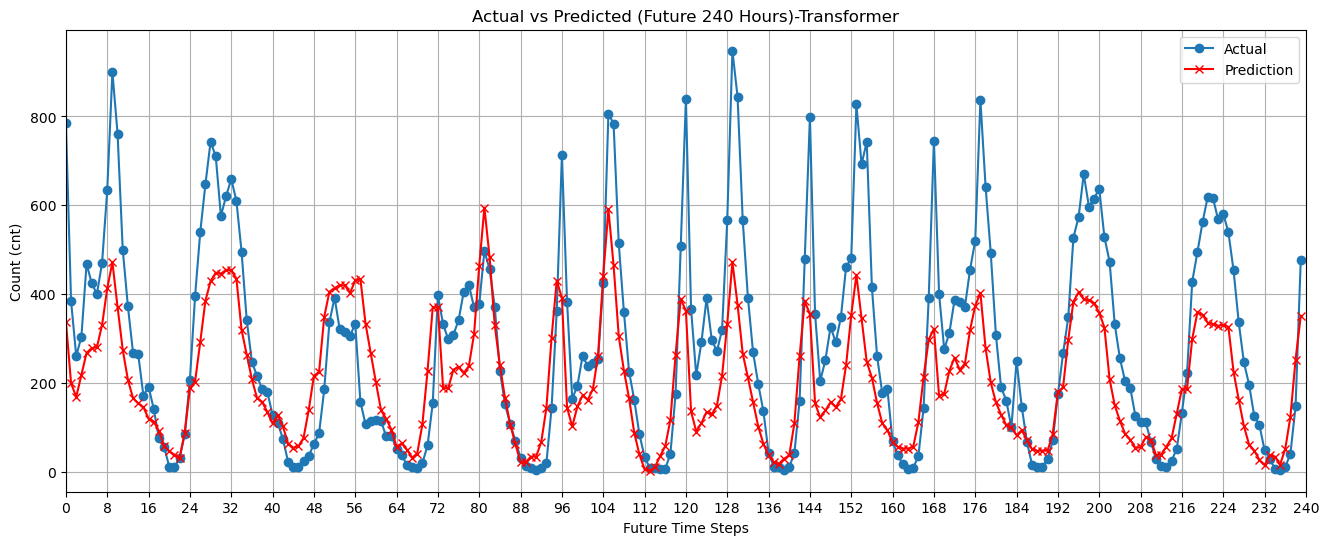

In [11]:
actual = scaler.inverse_transform(actuals[0][0])
prediction = scaler.inverse_transform(predictions[0][0].reshape(-1,1))
plt.figure(figsize=(16, 6))
plt.plot(actual, marker='o', label="Actual")  # 第一个批次，第一个样本的真实值
plt.plot(prediction, marker='x', label="Prediction", color='r')  # 第一个批次，第一个样本的预测值
plt.legend()
plt.title("Actual vs Predicted (Future 240 Hours)-Transformer")
plt.xlabel("Future Time Steps")
plt.ylabel("Count (cnt)")
plt.grid()

x_major_locator=MultipleLocator(8)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(0,240)
plt.show()

In [13]:
expn = 4
mse_list, real_mse_list = [], []
mae_list, real_mae_list = [], []
for i in range(expn):
    model_path = "Transformer240-"+str(i+1)+".pth"
    model = torch.load(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    with torch.no_grad():
        mse, mae, real_mse, real_mae = 0, 0, 0, 0
        for inputs, targets in test_loader:
            # inputs = inputs.transpose(0, 1)
            inputs = inputs.to(device)
            if len(inputs)!=32:
                continue
            # print(inputs.shape)
            y_pred = model(inputs).cpu().numpy()  # 预测值转为 NumPy 数组
            y_true = targets[:,:,0].cpu().numpy()  # 真实值转为 NumPy 数组
            # print(y_pred.shape, y_true.shape)
            y_true_inv = scaler.inverse_transform(y_true)
            y_pred_inv = scaler.inverse_transform(y_pred)
            mse += mean_squared_error(y_true, y_pred)
            mae += mean_absolute_error(y_true, y_pred)
            real_mse += mean_squared_error(y_true_inv, y_pred_inv)
            real_mae += mean_absolute_error(y_true_inv, y_pred_inv)
        print(f"Test {i+1}: MSE = {mse:.4f}, MAE = {mae:.4f}, real_mse = {real_mse:.4f}, real_mae = {real_mae:.4f}")
        mse_list.append(mse)
        real_mse_list.append(real_mse)
        mae_list.append(mae)
        real_mae_list.append(real_mae)
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)
real_average_mse = np.mean(real_mse_list)
real_average_mae = np.mean(real_mae_list)
mse_std = np.std(mse_list)
mae_std = np.std(mae_list)
real_mse_std = np.std(real_mse_list)
real_mae_std = np.std(real_mae_list)
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Real Average MSE: {real_average_mse:.4f}")
print(f"Real Average MAE: {real_average_mae:.4f}")
print(f"MSE STD: {mse_std:.4f}")
print(f"MAE STD: {mae_std:.4f}")
print(f"Real MSE STD: {real_mse_std:.4f}")
print(f"Real MAE STD: {real_mae_std:.4f}")

Test 1: MSE = 1.6461, MAE = 6.7682, real_mse = 1523370.5059, real_mae = 6510.9674
Test 2: MSE = 1.7730, MAE = 7.0981, real_mse = 1640792.9150, real_mae = 6828.3386
Test 3: MSE = 1.5934, MAE = 6.5484, real_mse = 1474559.4722, real_mae = 6299.5877
Test 4: MSE = 1.6404, MAE = 6.7513, real_mse = 1518067.7930, real_mae = 6494.7903
Average MSE: 1.6632
Average MAE: 6.7915
Real Average MSE: 1539197.6715
Real Average MAE: 6533.4210
MSE STD: 0.0666
MAE STD: 0.1970
Real MSE STD: 61637.3695
Real MAE STD: 189.5066
